In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import os
from keras import regularizers
# from tensorflow.keras.utils import get_confusion_matrix, plot_confusion_matrix

In [2]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=10

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/OTHERS/DhavalPatel/CV/Project/Pepper Project/Pepper',
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2475 files belonging to 2 classes.


In [4]:
class_names=dataset.class_names
class_names

['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy']

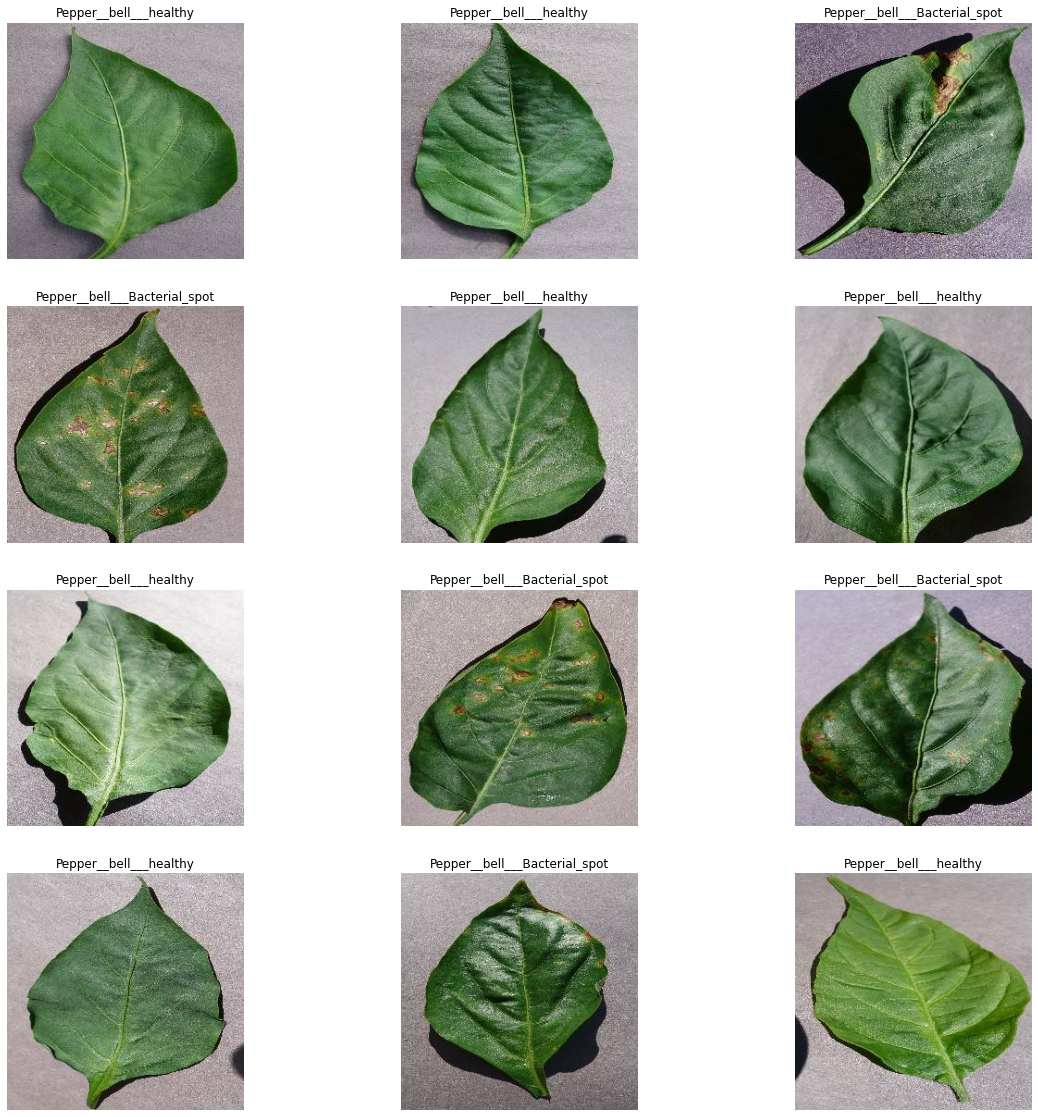

In [5]:
plt.figure(figsize=(20,20))
for image_batch,label_batch in dataset.take(1):
  for i in range(12):
    ax=plt.subplot(4,3,i+1)
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    plt.title(class_names[label_batch[i]])
    plt.axis('off')

In [6]:
def get_dataset(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
  
  ds_size=len(ds)

  if shuffle:
    ds=ds.shuffle(shuffle_size,seed=12)

  train_size=int(train_split*ds_size)
  val_size=int(val_split*ds_size)

  train_ds=ds.take(train_size)

  val_ds=ds.skip(train_size).take(val_size)
  test_ds=ds.skip(train_size).skip(val_size)

  return train_ds,val_ds,test_ds

In [7]:
train_ds,val_ds,test_ds=get_dataset(dataset)

In [8]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [9]:
resize_and_rescale=tf.keras.Sequential([
                                        layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
                                        layers.experimental.preprocessing.Rescaling(1.0/255),
])

In [10]:
data_augmentation=tf.keras.Sequential([
                                       layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
                                       layers.experimental.preprocessing.RandomRotation(0.3)
])

In [11]:
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
model=models.Sequential([
                         resize_and_rescale,
                         data_augmentation,
                         layers.Conv2D(64,(3,3),activation='relu',input_shape=input_shape),
                         layers.MaxPooling2D((2,2)),
                         layers.Conv2D(64,(3,3),activation='relu',kernel_regularizer=regularizers.L2(0.01)),layers.MaxPooling2D((2,2)),
                         layers.Conv2D(64,(3,3),activation='relu'),layers.MaxPooling2D((2,2)),
                         layers.Dropout(0.2),
                         layers.Conv2D(64,(3,3),activation='relu',kernel_regularizer=regularizers.L2(0.01)),layers.MaxPooling2D((2,2)),
                         layers.Conv2D(64,(3,3),activation='relu'),layers.MaxPooling2D((2,2)),
                         layers.Dropout(0.2),
                         layers.Conv2D(64,(3,3),activation='relu'),layers.MaxPooling2D((2,2)),
                         layers.Flatten(),
                         layers.Dense(64,activation='relu'),
                         layers.Dense(1,activation='sigmoid')
])

In [12]:
model.build(input_shape=input_shape)

In [13]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [14]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [15]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss',patience=2)

In [16]:
history=model.fit(train_ds,epochs=EPOCHS,batch_size=BATCH_SIZE,verbose=1,validation_data=val_ds,callbacks=[early_stopping])

Epoch 1/10
62/62 [==============================] - 26s 176ms/step - loss: 1.2309 - accuracy: 0.5940 - val_loss: 0.8395 - val_accuracy: 0.5970
Epoch 2/10
62/62 [==============================] - 10s 162ms/step - loss: 0.7054 - accuracy: 0.6623 - val_loss: 0.6015 - val_accuracy: 0.7412
Epoch 3/10
62/62 [==============================] - 11s 172ms/step - loss: 0.5031 - accuracy: 0.8258 - val_loss: 0.4601 - val_accuracy: 0.8299
Epoch 4/10
62/62 [==============================] - 10s 162ms/step - loss: 0.2498 - accuracy: 0.9266 - val_loss: 0.1914 - val_accuracy: 0.9501
Epoch 5/10
62/62 [==============================] - 9s 152ms/step - loss: 0.1646 - accuracy: 0.9674 - val_loss: 0.1167 - val_accuracy: 0.9740
Epoch 6/10
62/62 [==============================] - 9s 152ms/step - loss: 0.1014 - accuracy: 0.9832 - val_loss: 0.0727 - val_accuracy: 0.9949
Epoch 7/10
62/62 [==============================] - 9s 152ms/step - loss: 0.0712 - accuracy: 0.9924 - val_loss: 0.0534 - val_accuracy: 0.9954
Ep

In [17]:
scores=model.evaluate(test_ds)

62/62 [==============================] - 3s 40ms/step - loss: 0.1467 - accuracy: 0.9516


In [18]:
scores

[0.1467411071062088, 0.9516046643257141]

In [19]:
print(history.params)

{'verbose': 1, 'epochs': 10, 'steps': 62}


In [20]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [21]:
loss=history.history['loss']
accuracy=history.history['accuracy']
val_loss=history.history['val_loss']
val_accuracy=history.history['val_accuracy']

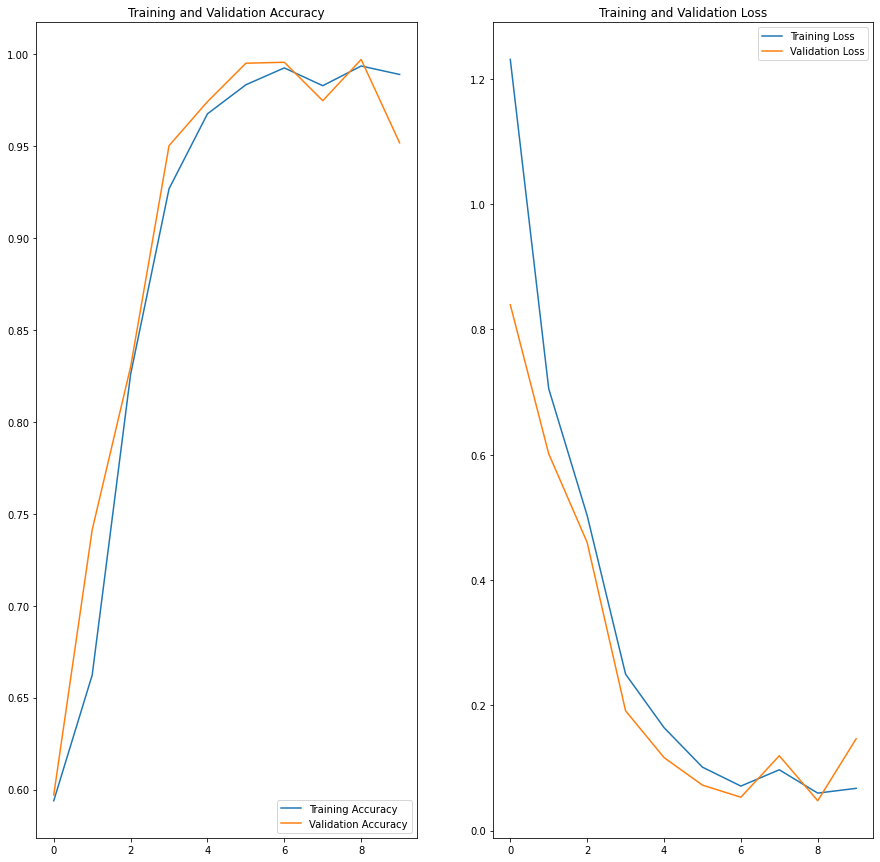

In [22]:
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),accuracy,label="Training Accuracy")
plt.plot(range(EPOCHS),val_accuracy,label="Validation Accuracy")
plt.legend(loc='lower right')
plt.title("Training and Validation Accuracy")

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label="Training Loss")
plt.plot(range(EPOCHS),val_loss,label="Validation Loss")
plt.legend(loc='upper right')
plt.title("Training and Validation Loss")
plt.show()

First image to predict
Actual Label:  Pepper__bell___Bacterial_spot
1/1 [==============================] - 0s 151ms/step
Predicted Label:  Pepper__bell___Bacterial_spot


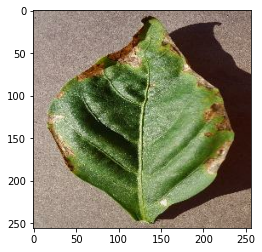

In [23]:
import numpy as np
for images_batch,labels_batch in test_ds.take(1):
  first_image=images_batch[2].numpy().astype('uint8')
  first_label=labels_batch[2].numpy()

  print("First image to predict")
  plt.imshow(first_image)
  print("Actual Label: ",class_names[first_label])

  batch_prediction=model.predict(images_batch)
  print("Predicted Label: ",class_names[(round(batch_prediction[2][0]))])
  # print(class_names[(round(batch_prediction[2][0]))])

In [24]:
def prediction(path):
  img = tf.keras.utils.load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
  img_array = tf.keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array,0)
  predict = model.predict(img_array)
  if predict>0.5:  
    predicted_class = class_names[round(predict[0][0])]
  else:
    predicted_class = class_names[round(predict[0][0])]
  plt.title(predicted_class)
  plt.imshow(img)
  plt.show()

1/1 [==============================] - 0s 212ms/step


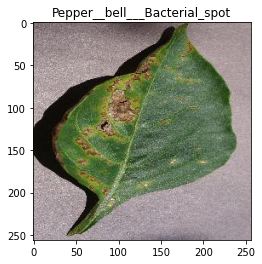

In [25]:
prediction('/content/drive/MyDrive/OTHERS/DhavalPatel/CV/Project/Pepper Project/Pepper/Pepper__bell___Bacterial_spot/0022d6b7-d47c-4ee2-ae9a-392a53f48647___JR_B.Spot 8964.JPG')

1/1 [==============================] - 0s 22ms/step


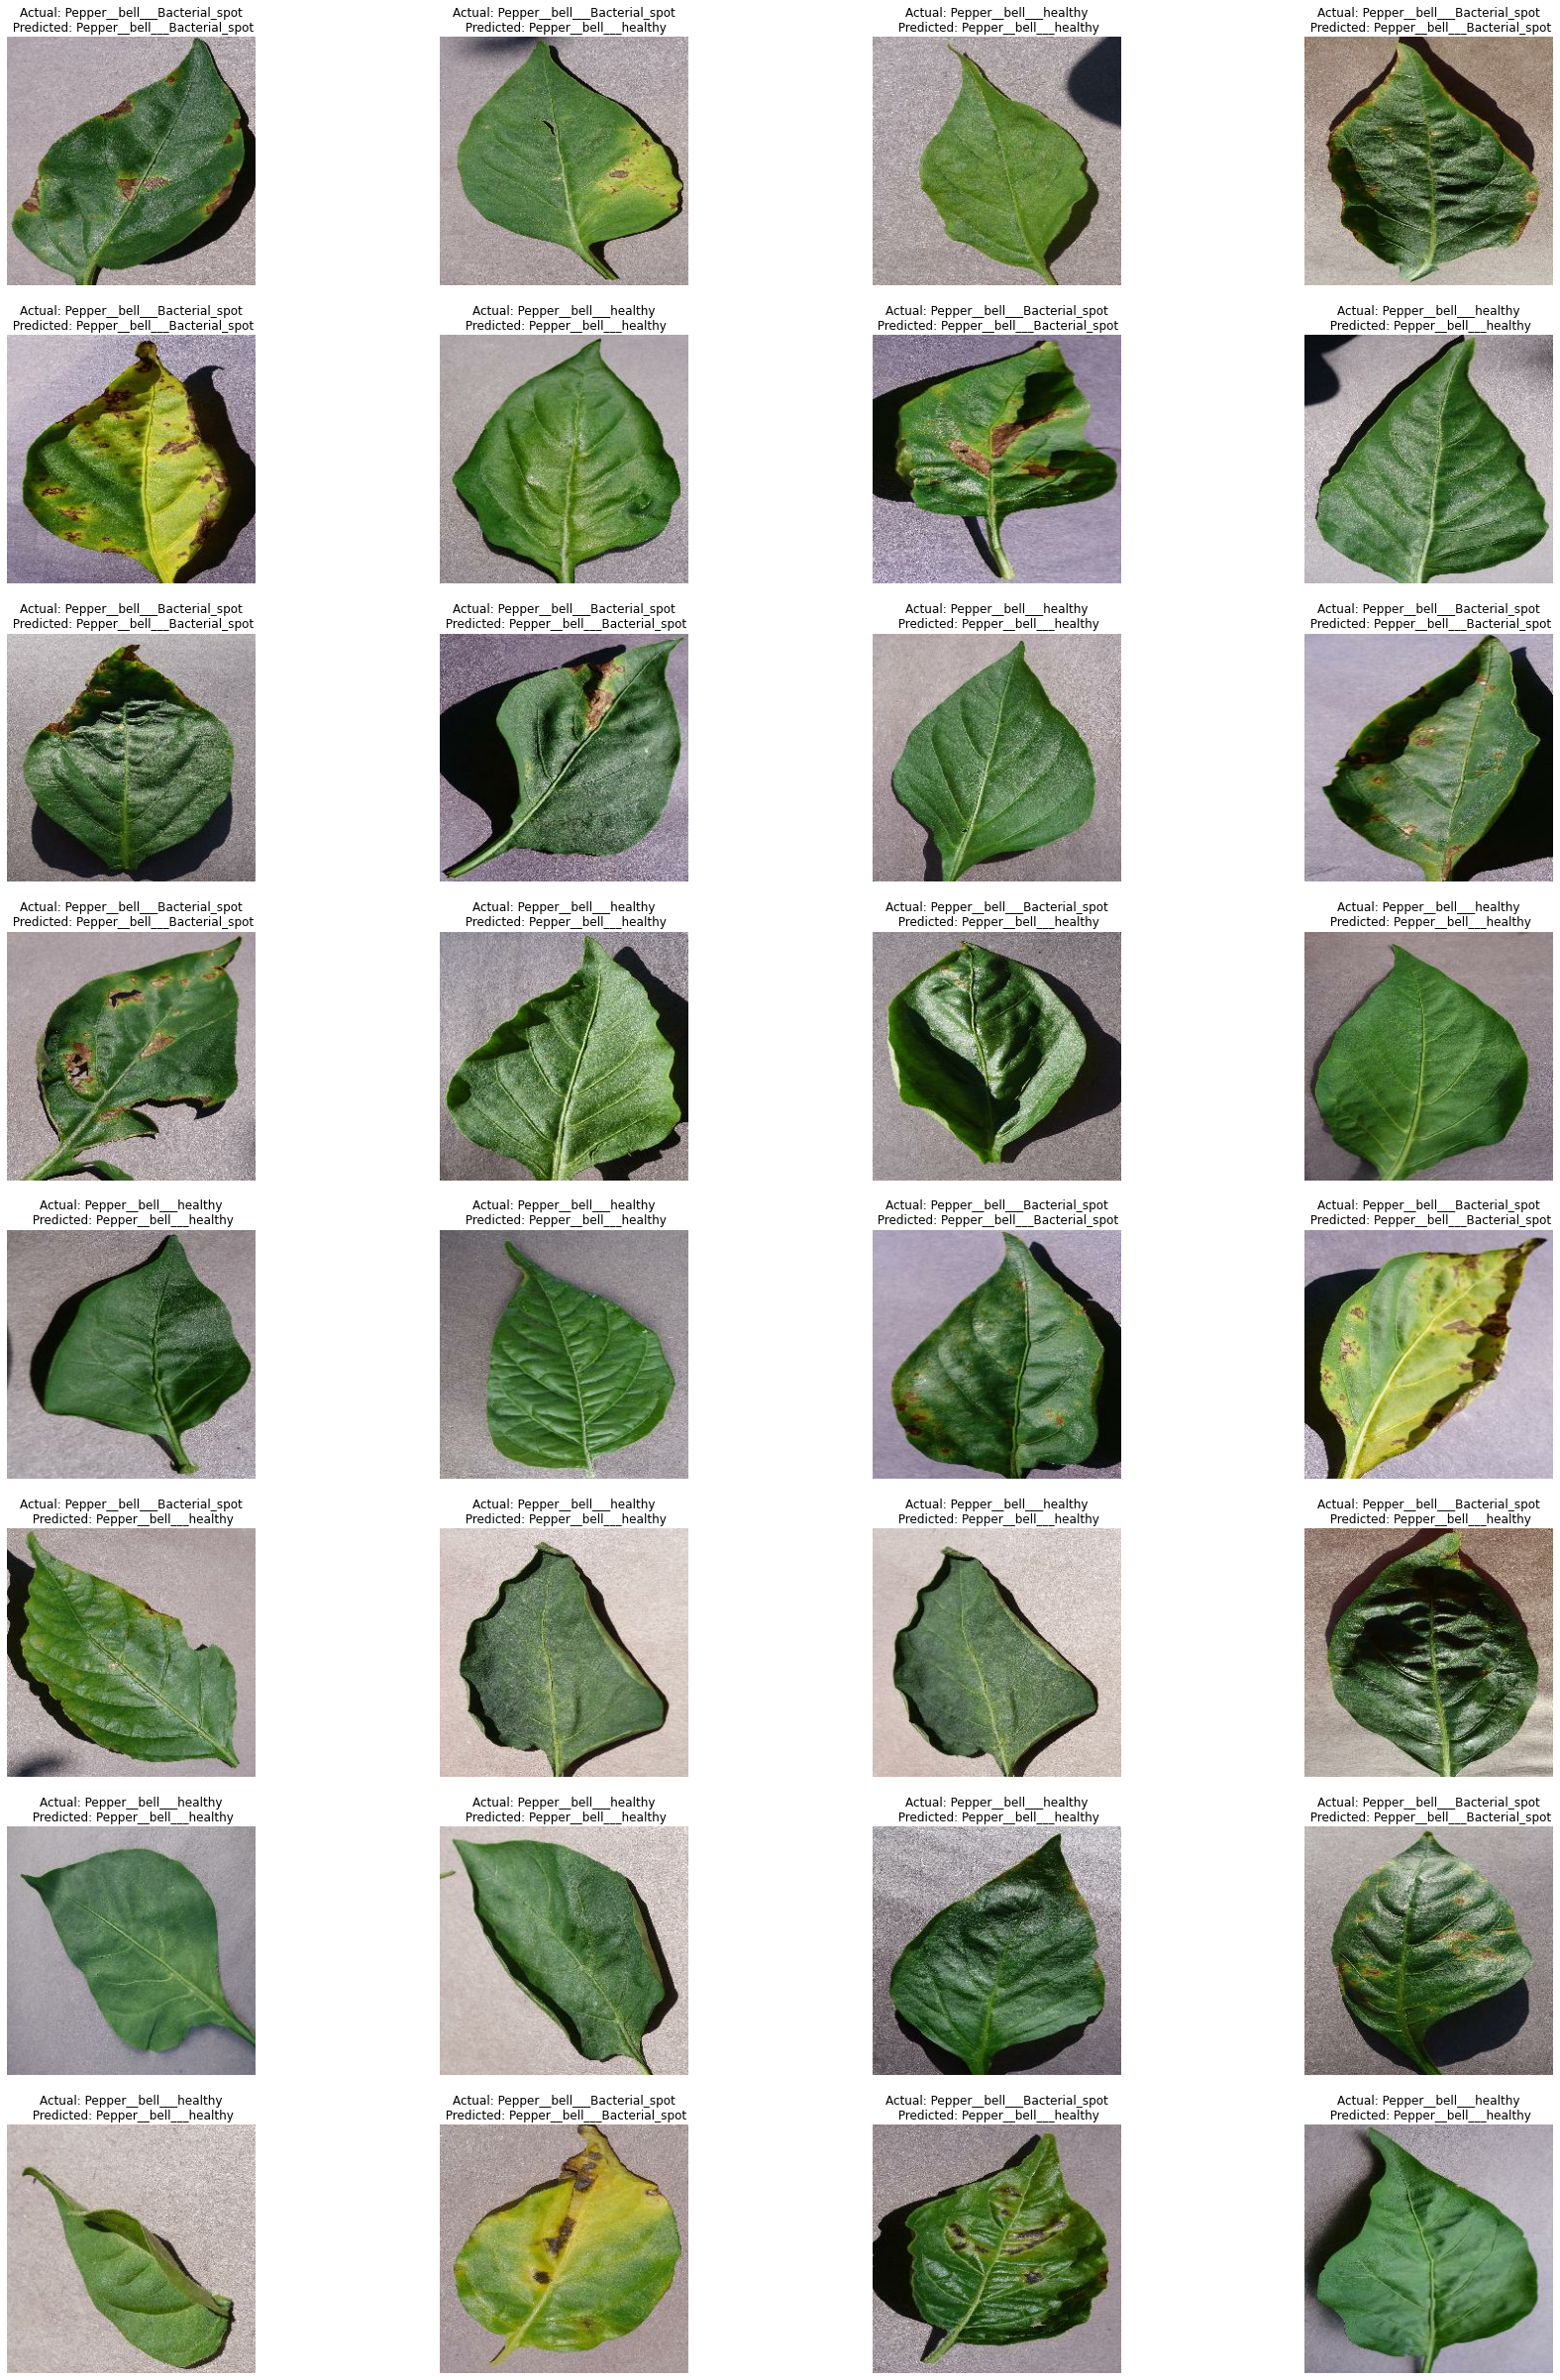

In [26]:
plt.figure(figsize=(30,60))
for images,labels in test_ds.take(1):
  for i in range(32):
    plt.subplot(11,4,i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)
    predictions=model.predict(img_array)
    predicted_class=class_names[round(predictions[0][0])]
    actual_class=class_names[labels[i]]
    plt.title(f"Actual: {actual_class}\n Predicted: {predicted_class}")
    plt.axis('off')